In [6]:
import torch
from torch import nn
import numpy as np
import pickle
import pandas as pd
from itertools import product

# Cargar datos

## Embeddings

In [8]:
with open('index_item_and_embedding_matrix_dict.pickle', 'rb') as f:
    index_emb_dict = pickle.load(f)

index_item_matrix = torch.LongTensor(index_emb_dict['index_item_matrix'])
embedding_matrix = torch.Tensor(index_emb_dict['embedding_matrix'])
unique_tokens_d = index_emb_dict['unique_tokens_d']

In [9]:
index_item_matrix.shape

torch.Size([10681, 39])

In [11]:
n_items = index_item_matrix.shape[0]
embedding_matrix.shape

torch.Size([10701, 300])

In [12]:
n_items

10681

## Ratings

In [13]:
PID = "spike-sandbox"

query = """
SELECT *
FROM EVIC.ratings
"""
ratings = pd.read_gbq(query, project_id=PID, use_bqstorage_api=True)

In [76]:
ratings.head()

,user_id,movie_id,rating
0,8,1204,2.0
1,8,1388,2.0
2,8,2548,2.0
3,12,3608,2.0
4,13,4502,2.0


In [100]:
n_users = ratings.user_id.nunique()

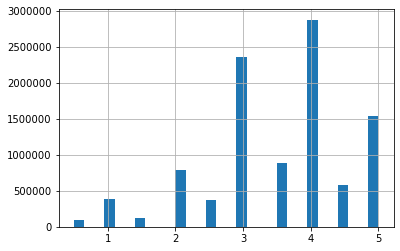

In [80]:
ratings.rating.hist(bins=30)

## Generar índices de peliculas y usuarios

In [86]:
ratings['movie_id'] = ratings['movie_id'].astype("category")
ratings['movie_idx'] = ratings['movie_id'].cat.codes

movie_dict = pd.concat([ratings['movie_id'], ratings['movie_idx']], axis=1)
movie_dict.rename(columns={0: 'id'}, inplace=True)

movie_dict = movie_dict.drop_duplicates().sort_values(by='movie_idx')
movie_dict.set_index('movie_idx', inplace=True)

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['user_idx'] = ratings['user_id'].cat.codes

user_dict = pd.concat([ratings['user_id'], ratings['user_idx']], axis=1)
user_dict.rename(columns={0: 'id'}, inplace=True)

user_dict = user_dict.drop_duplicates().sort_values(by='user_idx')
user_dict.set_index('user_idx', inplace=True)

In [87]:
ratings.head()

,user_id,movie_id,rating,movie_idx,user_idx
0,8,1204,2.0,1179,7
1,8,1388,2.0,1357,7
2,8,2548,2.0,2464,7
3,12,3608,2.0,3519,11
4,13,4502,2.0,4409,12


## Generar preference

In [88]:
ratings_matrix = pd.pivot_table(ratings, index='movie_idx', columns='user_idx', values='rating')

In [97]:
sparcity = round(100 * ratings_matrix.isna().sum().sum() / ratings_matrix.size, 2)
print(f'sparcity = {sparcity}%')

sparcity = 98.66%


In [98]:
ratings_matrix = ratings_matrix.fillna(0)

In [135]:
rating_thresh = 3.5

ratings_full = ratings_matrix.unstack().to_frame('rating').reset_index()
ratings_full['preference'] = ratings_full.eval(f'(rating >= {rating_thresh})').astype('int')

movie_idx = torch.LongTensor(ratings_full['movie_idx'].values)
user_idx = torch.LongTensor(ratings_full['user_idx'].values)
cofidence = torch.Tensor(ratings_full['rating'].values)
preference = torch.Tensor(ratings_full['preference'].values)


ratings_full.head()

,user_idx,movie_idx,rating,preference
0,0,0,0.0,0
1,0,1,0.0,0
2,0,2,0.0,0
3,0,3,0.0,0
4,0,4,0.0,0


In [136]:
ratings_full.movie_idx.max()

10676

In [ ]:
ratings_full[['rating', 'preference']].hist(bins=20, figsize=(10, 5));

# Modelo

## Definir modelo

In [122]:
def trunc_normal_(x, mean=0, std=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

def embedding(ni:int,nf:int):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_users_factors, 
                 n_users, n_items, index_item_matrix, embedding_matrix, y_range=None):
        super().__init__()
        self.y_range = y_range
        #generar embedings de usuarios y bias de usuarios e items
        (self.u_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_users_factors), (n_users, 1), (n_items, 1)]]
        
        self.index_item_matrix = index_item_matrix # N_glosas x Largo_maximo_glosas 
        self.embedding_matrix = embedding_matrix # (N_palabras + 1) x N_latentes
        
        self.largo_max_glosas = index_item_matrix.shape[1]
        self.n_latent = embedding_matrix.shape[1]
        #https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d
        kernel_size = self.largo_max_glosas * self.n_latent - n_users_factors + 1
        self.conv = torch.nn.Conv1d(1, 1, kernel_size=kernel_size)

    def forward(self, users, items):
        idx_items = self.index_item_matrix[items] #indices de palabras en las glosas Nitems x Largo_max
        i_weights_full = self.embedding_matrix[idx_items] #latentes de glosas
        i_weight = self.conv(i_weights_full.reshape((len(items), 1, -1))).squeeze()
        dot = self.u_weight(users) * i_weight
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

## Inicializar

In [123]:
n_users_factors = 30
model = EmbeddingDotBias(n_users_factors, n_users, n_items, index_item_matrix, embedding_matrix)

In [127]:
index_item_matrix.shape

torch.Size([10681, 39])

In [125]:
model(movie_idx, user_idx)

IndexError: index 10681 is out of bounds for dimension 0 with size 10681

In [20]:
m(items,items)

torch.Size([2, 28])
torch.Size([2, 28])


tensor([0.0342, 0.0004], grad_fn=<AddBackward0>)

In [21]:
index_item_matrix[items]

tensor([[10,  7,  0, 10,  1,  6,  7, 10],
        [ 5, 10,  3,  6,  7,  2,  5,  2]])

In [23]:
embedding_matrix[index_item_matrix[items]]

tensor([[[-1.2850,  1.5635, -0.7636,  0.9608,  1.2668],
         [-0.0930, -2.2290, -0.7536,  0.2702, -0.4928],
         [-0.5741,  0.9674,  0.8741, -1.4479, -0.1094],
         [-1.2850,  1.5635, -0.7636,  0.9608,  1.2668],
         [ 0.7824,  1.8313, -1.7600,  0.7079,  0.2829],
         [ 1.1292,  1.7602, -0.2368, -0.3784, -0.0589],
         [-0.0930, -2.2290, -0.7536,  0.2702, -0.4928],
         [-1.2850,  1.5635, -0.7636,  0.9608,  1.2668]],

        [[ 0.0204, -1.2497, -0.7541, -0.8382,  1.0691],
         [-1.2850,  1.5635, -0.7636,  0.9608,  1.2668],
         [ 1.6832, -0.1488, -1.0298, -0.0191,  1.8393],
         [ 1.1292,  1.7602, -0.2368, -0.3784, -0.0589],
         [-0.0930, -2.2290, -0.7536,  0.2702, -0.4928],
         [ 0.2636, -2.5898,  0.6262, -1.4697, -0.7319],
         [ 0.0204, -1.2497, -0.7541, -0.8382,  1.0691],
         [ 0.2636, -2.5898,  0.6262, -1.4697, -0.7319]]])

In [24]:
embedding_matrix[index_item_matrix[items]].shape

torch.Size([2, 8, 5])

In [27]:
embedding_matrix[index_item_matrix[items]].reshape((2, -1))

tensor([[-1.2850,  1.5635, -0.7636,  0.9608,  1.2668, -0.0930, -2.2290, -0.7536,
          0.2702, -0.4928, -0.5741,  0.9674,  0.8741, -1.4479, -0.1094, -1.2850,
          1.5635, -0.7636,  0.9608,  1.2668,  0.7824,  1.8313, -1.7600,  0.7079,
          0.2829,  1.1292,  1.7602, -0.2368, -0.3784, -0.0589, -0.0930, -2.2290,
         -0.7536,  0.2702, -0.4928, -1.2850,  1.5635, -0.7636,  0.9608,  1.2668],
        [ 0.0204, -1.2497, -0.7541, -0.8382,  1.0691, -1.2850,  1.5635, -0.7636,
          0.9608,  1.2668,  1.6832, -0.1488, -1.0298, -0.0191,  1.8393,  1.1292,
          1.7602, -0.2368, -0.3784, -0.0589, -0.0930, -2.2290, -0.7536,  0.2702,
         -0.4928,  0.2636, -2.5898,  0.6262, -1.4697, -0.7319,  0.0204, -1.2497,
         -0.7541, -0.8382,  1.0691,  0.2636, -2.5898,  0.6262, -1.4697, -0.7319]])